In [2]:
%set_env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)

# Solving the Stokes equation on a topological cylinder with Dirichlet BCs

Initial time = 10
2023-06-01 14:11:32,862 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 3s, Rate: 1.2e+01/s
2023-06-01 14:11:32,973 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 2.0e+01/s
2023-06-01 14:11:33,120 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 2.3e+01/s
2023-06-01 14:11:33,266 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 2.4e+01/s
2023-06-01 14:11:33,415 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s
2023-06-01 14:11:33,562 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 2.5e+01/s
2023-06-01 14:11:33,709 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 2.6e+01/s
2023-06-01 14:11:33,857 subsystems 0/1 INFO :: Building

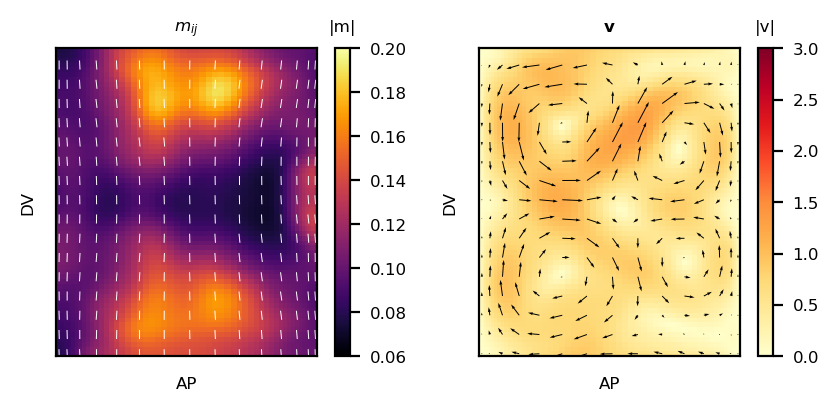

Signature: problem.build_solver(*args, **kw)
Docstring: Build corresponding solver class.
File:      /project/vitelli/dedalus_venv/lib/python3.10/site-packages/dedalus/core/problems.py
Type:      method


In [76]:
from scipy.interpolate import RectBivariateSpline
folder = '../for_michel/data'
tt = 20
t0 = np.load(f'{folder}/time.npy')
print(f'Initial time = {t0[tt]}')
m0 = np.load(f'{folder}/myosin.npy', mmap_mode='r')[tt, ..., 20:-20]

def get_g_with_scales(field, scales):
    f = field.copy()
    f.change_scales(scales)
    return f["g"]

Lx, Ly = 452., 533.
Nx, Ny = 64, 64

dealias = 3/2
mu, α = 1, 3

# Bases
coords = d3.CartesianCoordinates("x", "y")
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.Chebyshev(  coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2,Ly/2), dealias=dealias)

# Fields
v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
m = dist.TensorField(coords, name="m", bases=(xbasis,ybasis))
p = dist.ScalarField(name='p', bases=(xbasis,ybasis))

# Forcing conditions
x, y = dist.local_grids(xbasis, ybasis)
x0 = np.linspace(-Lx/2, Lx/2, m0.shape[-1])
y0 = np.linspace(-Ly/2, Ly/2, m0.shape[-2])
m["g"][0,0,:,:] = RectBivariateSpline(x0, y0, m0[3].T)(x, y)
m["g"][0,1,:,:] = RectBivariateSpline(x0, y0, m0[1].T)(x, y)
m["g"][1,0,:,:] = m['g'][0,1,:,:]
m["g"][1, 1,:,:] = RectBivariateSpline(x0, y0, m0[0].T)(x, y)

#Tau terms
tau_p  = dist.Field(name='tau_p')  #Residual for pressure
tau_vy = dist.Field(name='tau_v') #Residual for y-component of velocity
tau_v1 = dist.VectorField(coords, name='tau_v1', bases=ybasis)
tau_v2 = dist.VectorField(coords, name='tau_v2', bases=ybasis)

#Substitutions
ex, ey = coords.unit_vector_fields(dist)
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_v = d3.grad(v) - ex*lift(tau_v1)

#Static velocity Problem
problem = d3.LBVP([v, p, tau_p, tau_vy, tau_v1, tau_v2], namespace=locals())
problem.add_equation("mu*div(grad_v) - grad(p) + lift(tau_v2) + tau_vy*ey = -α * div(m) ") # Stokes equation (with tau residual)
problem.add_equation("trace(grad_v) + tau_p = 0")  #Incompressibility (with tau residual)

#Boundary conditions
problem.add_equation("v(x=-Lx/2) = 0") #Dirichlet BC 
problem.add_equation("v(x=+Lx/2) = 0") #Dirichlet BC
problem.add_equation("integ(p) = 0")        #Zero-mean pressure gauge
problem.add_equation("integ(v @ ey) = 0")   #No net y-flow gauge

# Solver
solver = problem.build_solver()
solver.solve()

x = np.squeeze(xbasis.local_grid())
y = np.squeeze(ybasis.local_grid())
vi = get_g_with_scales(v, (1, 1))
mij = get_g_with_scales(m, (1, 1))

# Plot
fig, ax = plt.subplots(1, 2, dpi=200, figsize=(5, 2))

mij = mij.transpose(2, 3, 0, 1)
m = np.linalg.norm(mij, axis=(2, 3))
el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
n = ev[..., 1]

pcM = ax[0].pcolormesh(x, y, m.T, cmap='inferno', vmin=0.06, vmax=0.2)
skip = 4
X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
ax[0].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T,
             pivot='middle', color='white',
             headwidth=0, headlength=0, headaxislength=0)

cb = plt.colorbar(pcM, ax=ax[0])
cb.ax.set_title("|m|")
ax[0].set_title(r'$m_{ij}$')

pcV = ax[1].pcolormesh(x, y, np.linalg.norm(vi, axis=0).T, vmin=0, vmax=3, cmap='YlOrRd')
ax[1].quiver(X, Y, vi[0, ::skip, ::skip].T, vi[1, ::skip, ::skip].T, 
             color="black")
cb = plt.colorbar(pcV, ax=ax[1])
cb.ax.set_title("|v|")
ax[1].set_title(r'$\mathbf{v}$')

for a in ax:
    a.set(xlabel='AP', ylabel='DV', 
          xticks=[], yticks=[], 
          aspect='equal')
    
problem.build_solver?

# Minimal closed-loop model on a topological cylinder

\begin{equation}
    \mu \nabla^2 \mathbf{v} - \nabla P + \alpha \nabla \cdot  \overleftrightarrow{m} = 0
    \label{eq:stokes}
\end{equation}

\begin{equation}
    \partial_t c + (\mathbf{v} \cdot \nabla) c = 0
    \label{eq:cadherinadvection}
\end{equation}

\begin{equation}
    \partial_t m_{ij} + (\mathbf{v} \cdot \nabla) m_{ij} + [\Omega, m]_{ij} = 
    -\frac{1}{\tau} (1 - \delta_c c) m_{ij} + 
    k_E (1 + \alpha_c c) m_{ij} E_{kk} + 
    k_m (1 - \beta_c c) m_{ij} m_{kk} + 
    k_{\Gamma} (1 - \gamma_c) \Gamma_{ij}^{DV} m_{kk}
    \label{eq:myosinmodel}
\end{equation}

In [58]:
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 6

def get_director_magnitude(mij):
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]
    return m, n

def plot_all(mij, vi, c, t0, x, y, mmin=None, mmax=None, vmax=None, skip=5, half=False):
    if half:
        fig, ax = plt.subplots(5, 3, dpi=200, figsize=(6, 5.5))
    else:
        fig, ax = plt.subplots(5, 3, dpi=200, figsize=(6, 10))

    ax[-1, 0].plot(t0, np.mean(np.linalg.norm(mij, axis=(1, 2)), axis=(1, 2)), 
                   color='firebrick', label=r"$\langle|\!|m|\!|\rangle_{{\rm space}}$")    
    ax[-1, 1].plot(t0[1:], np.mean(np.linalg.norm(vi[1:], axis=(1)), axis=(1, 2)),
                   color='black', label=r"$\langle|\!|v|\!|\rangle_{{\rm space}}$")
    ax[-1, 2].plot(t, np.mean(c, axis=(1, 2)),
                   color='steelblue', label=r"$\langle|c|\rangle_{{\rm space}}$")
    for a in ax[-1]:
        a.set_xlabel('Time')
        a.tick_params(which='both', direction='in')
        a.legend(framealpha=False)
    

    m0, m1 = mij[1], mij[-1]
    v0, v1 = vi[1],  vi[-1]
    c0, c1 = c[1],   c[-1]
    w0 = np.gradient(v0[1], x, axis=-2) - np.gradient(v0[1], y, axis=-1)
    w1 = np.gradient(v1[1], x, axis=-2) - np.gradient(v1[1], y, axis=-1)
    wmax = max(max(abs(np.min(w0)), np.max(w0)), max(abs(np.min(w1)), np.max(w1)))
        
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
    
    for i, (mi, v, w, ci) in enumerate([(m0, v0, w0, c0), (m1, v1, w1, c1)]):
        m, n = get_director_magnitude(mi)
        pcM = ax[0, i].pcolormesh(x, y, m.T, cmap='inferno', vmin=mmin, vmax=mmax)
        ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)
        
        pcV = ax[1, i].pcolormesh(x, y, np.linalg.norm(v, axis=0).T, vmin=0, vmax=vmax, cmap='YlOrRd')
        ax[1, i].quiver(X, Y, v[0, ::skip, ::skip].T, v[1, ::skip, ::skip].T, color="black")
        pcW = ax[2, i].pcolormesh(x, y, w.T, cmap='PiYG', vmin=-wmax, vmax=wmax)
        
        pcC = ax[3, i].pcolormesh(x, y, ci.T, cmap='viridis')
        
    cb = plt.colorbar(pcM, ax=ax[0, i])
    cb.ax.set_title("|m|")
        
    cb = plt.colorbar(pcV, ax=ax[1, i])
    cb.ax.set_title("|v|")
    
    cb = plt.colorbar(pcW, ax=ax[2, i])
    cb.ax.set_title('$\\omega$')
    
    cb = plt.colorbar(pcC, ax=ax[3, i])
    cb.ax.set_title('c')
    
    pcM = ax[0, -1].pcolormesh(x, y, m.T, cmap='inferno')
    ax[0, -1].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)
    cb = plt.colorbar(pcM, ax=ax[0, -1])
    cb.ax.set_title("|m|")
        
    pcV = ax[1, -1].pcolormesh(x, y, np.linalg.norm(v, axis=0).T, cmap='YlOrRd')
    ax[1, -1].quiver(X, Y, v[0, ::skip, ::skip].T, v[1, ::skip, ::skip].T, color="black")
    cb = plt.colorbar(pcV, ax=ax[1, -1])
    cb.ax.set_title("|v|")
    
    pcW = ax[2, -1].pcolormesh(x, y, w.T, cmap='PiYG')
    cb = plt.colorbar(pcW, ax=ax[2, -1])
    cb.ax.set_title("$\\omega$")
    
    pcC = ax[3, -1].pcolormesh(x, y, ci.T, cmap='viridis')
    cb = plt.colorbar(pcC, ax=ax[3, -1])
    cb.ax.set_title("$c$")

    for a in ax[:-1].flatten():
        a.set(xticks=[], yticks=[], aspect='equal')
        if half:
            a.set_ylim([a.get_ylim()[0], 0])
    ax[0, 0].set_title('Initial condition')
    ax[0, 1].set_title('Final condition')
    ax[0, 2].set_title('Final (color unnormalized)')
        
    fig.subplots_adjust(wspace=0.02)

In [147]:
def get_g_with_scales(field, scales):
    f = field.copy()
    f.change_scales(scales)
    return f["g"]

def simu(params, set_initial_conditions, logger):
    # params: dict containing all parameters
    # initial_conditions: function (dist, (xbasis, ybasis), c, v, m) -> None that should modify the [d3.Field]s c,v,m
    # logger: logging.Logger
    Lx, Ly = params["Lx"], params["Ly"]
    Nx, Ny = params["Nx"], params["Ny"]
    dealias = 3/2
    
    mu = params["mu"]
    α  = params["α"]
    τ  = params.get("τ", 1e5)
    A  = params.get("A", 0)
    B  = params.get("B", 0)
    C  = params.get("C", 0)
    D  = params.get("D", 0)
    km = params.get("km", 0)
    kE = params.get("kE", 0)
    
    # Bases
    coords = d3.CartesianCoordinates("x", "y")
    dist = d3.Distributor(coords, dtype=np.float64)
    xbasis = d3.ChebyshevT( coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
    ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)

    # Fields
    c = dist.ScalarField(name='c', bases=(xbasis,ybasis))
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis, ybasis))
    p = dist.Field(name='p', bases=(xbasis,ybasis))
    tau_p  = dist.Field(name='tau_p')  #Residual for pressure
    tau_vy = dist.Field(name='tau_vy') #Residual for y-component of velocity
    tau_v1 = dist.VectorField(coords, name='tau_v1', bases=ybasis)
    tau_v2 = dist.VectorField(coords, name='tau_v2', bases=ybasis)

    #Substitutions
    Ω = (d3.grad(v) - d3.transpose(d3.grad(v))) / 2
    E = (d3.grad(v) + d3.transpose(d3.grad(v))) / 2
    ex, ey = coords.unit_vector_fields(dist)
    
    lift_basis = xbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    grad_v = d3.grad(v) - ex*lift(tau_v1)

    #Static velocity Problem
    problem = d3.IVP([c, m, v, p, tau_p, tau_vy, tau_v1, tau_v2], namespace=locals())
    problem.add_equation("mu*div(grad_v) - grad(p) + lift(tau_v2) + ey*tau_vy = -α * div(m) ") # Stokes equation (with tau residual)
    problem.add_equation("trace(grad_v) + tau_p = 0")  #Incompressibility (with tau residual)
    
    #Boundary conditions
    problem.add_equation("v(x=-Lx/2) = 0") #Dirichlet BCs 
    problem.add_equation("v(x=+Lx/2) = 0") #DIrichlet BC
    problem.add_equation("integ(p) = 0")        #Zero-mean pressure gauge
    problem.add_equation("integ(v @ ey) = 0")   #No net y-flow gauge
    
    #Protein fields
    problem.add_equation("dt(c) = - v@grad(c)") #Cadherin advection
    problem.add_equation(params['m_eq'])
    
    # Solver
    solver = problem.build_solver(d3.SBDF2)
    solver.stop_sim_time = params['max_time']

    # Initial conditions
    set_initial_conditions(dist=dist, bases=(xbasis, ybasis), params=params, c=c, v=v, m=m)
    
    # Main loop
    save_every = params["save_every"]
    t_list, c_list, m_list, v_list = [], [], [], []
    try:
        logger.info("Starting main loop")
        while solver.proceed:
            if solver.iteration % save_every == 0:
                t_list.append(solver.sim_time)
                c_list.append(get_g_with_scales(c, (1,1)))
                m_list.append(get_g_with_scales(m, (1,1)))
                v_list.append(get_g_with_scales(v, (1,1)))
            solver.step(params['timestep'])
            if np.isnan(np.mean(v["g"])) or np.isnan(np.mean(m["g"])) or np.isnan(np.mean(c["g"])):
                raise Exception("computation diverges: adjust dt and/or dx")
                solver.stop_iteration = 0
            if (solver.iteration-1) % 100 == 0:
                logger.info(f"Iteration={solver.iteration}, Time={solver.sim_time}, dt={params['timestep']}")
    except:
        logger.error("Exception raised, triggering end of main loop.")
        raise
        
    return {"params": params, 
            "fields": {"c":c, "v": v, "m": m}, 
            "bases": (xbasis, ybasis),
            "trajectory": {"c": c_list, "v": v_list, "m": m_list, "t": t_list}}


def ics(dist, bases, params, c, v, m):
    xbasis, ybasis = bases
    x, y = dist.local_grids(xbasis, ybasis)
    Lx, Ly = params['Lx'], params['Ly']
    if params['m_ic'] is None:
        x0 = np.linspace(-Lx/2, Lx/2, m0.shape[-1])
        y0 = np.linspace(-Ly/2, Ly/2, m0.shape[-2])
        m["g"][0,0,:,:] = RectBivariateSpline(x0, y0, m0[3].T)(x, y)
        m["g"][0,1,:,:] = RectBivariateSpline(x0, y0, m0[1].T)(x, y)
        m["g"][1,0,:,:] = m['g'][0,1,:,:]
        m["g"][1, 1,:,:] = RectBivariateSpline(x0, y0, m0[0].T)(x, y)
    else:
        m['g'] = params['m_ic']
        
    if params['c_ic'] is None:
        x0 = np.linspace(-Lx/2, Lx/2, c0.shape[-1])
        y0 = np.linspace(-Ly/2, Ly/2, c0.shape[-2])
        c['g'][:] = RectBivariateSpline(x0, y0, c0.T)(x, y)
    else:
        c["g"] = 0.8 + 0.2 * (1 + np.cos(2*np.pi*y/Ly))*(1+np.cos(2*np.pi*x/Lx))
    
    v["g"][:] = 0

## Summary of myosin-cadherin cases

1. $D_t m_{ij} = \frac{1}{\tau} (1 + k_0 c) m_{ij} + A m_{ij} m_{kk}$
    - Fixed point $m_{ij} = 0$
    - Fixed point $m_{kk} = -\frac{1}{\tau A} (1 + k_0 c)$

Initial time = -10
Fixed point at 0.3333333333333333
2023-06-01 16:18:00,693 dedalus 0/1 INFO :: Starting main loop
2023-06-01 16:18:00,780 dedalus 0/1 INFO :: Iteration=1, Time=0.1, dt=0.1
2023-06-01 16:18:02,538 dedalus 0/1 INFO :: Iteration=101, Time=10.09999999999998, dt=0.1
2023-06-01 16:18:04,258 dedalus 0/1 INFO :: Iteration=201, Time=20.100000000000016, dt=0.1
2023-06-01 16:18:05,957 solvers 0/1 INFO :: Simulation stop time reached.


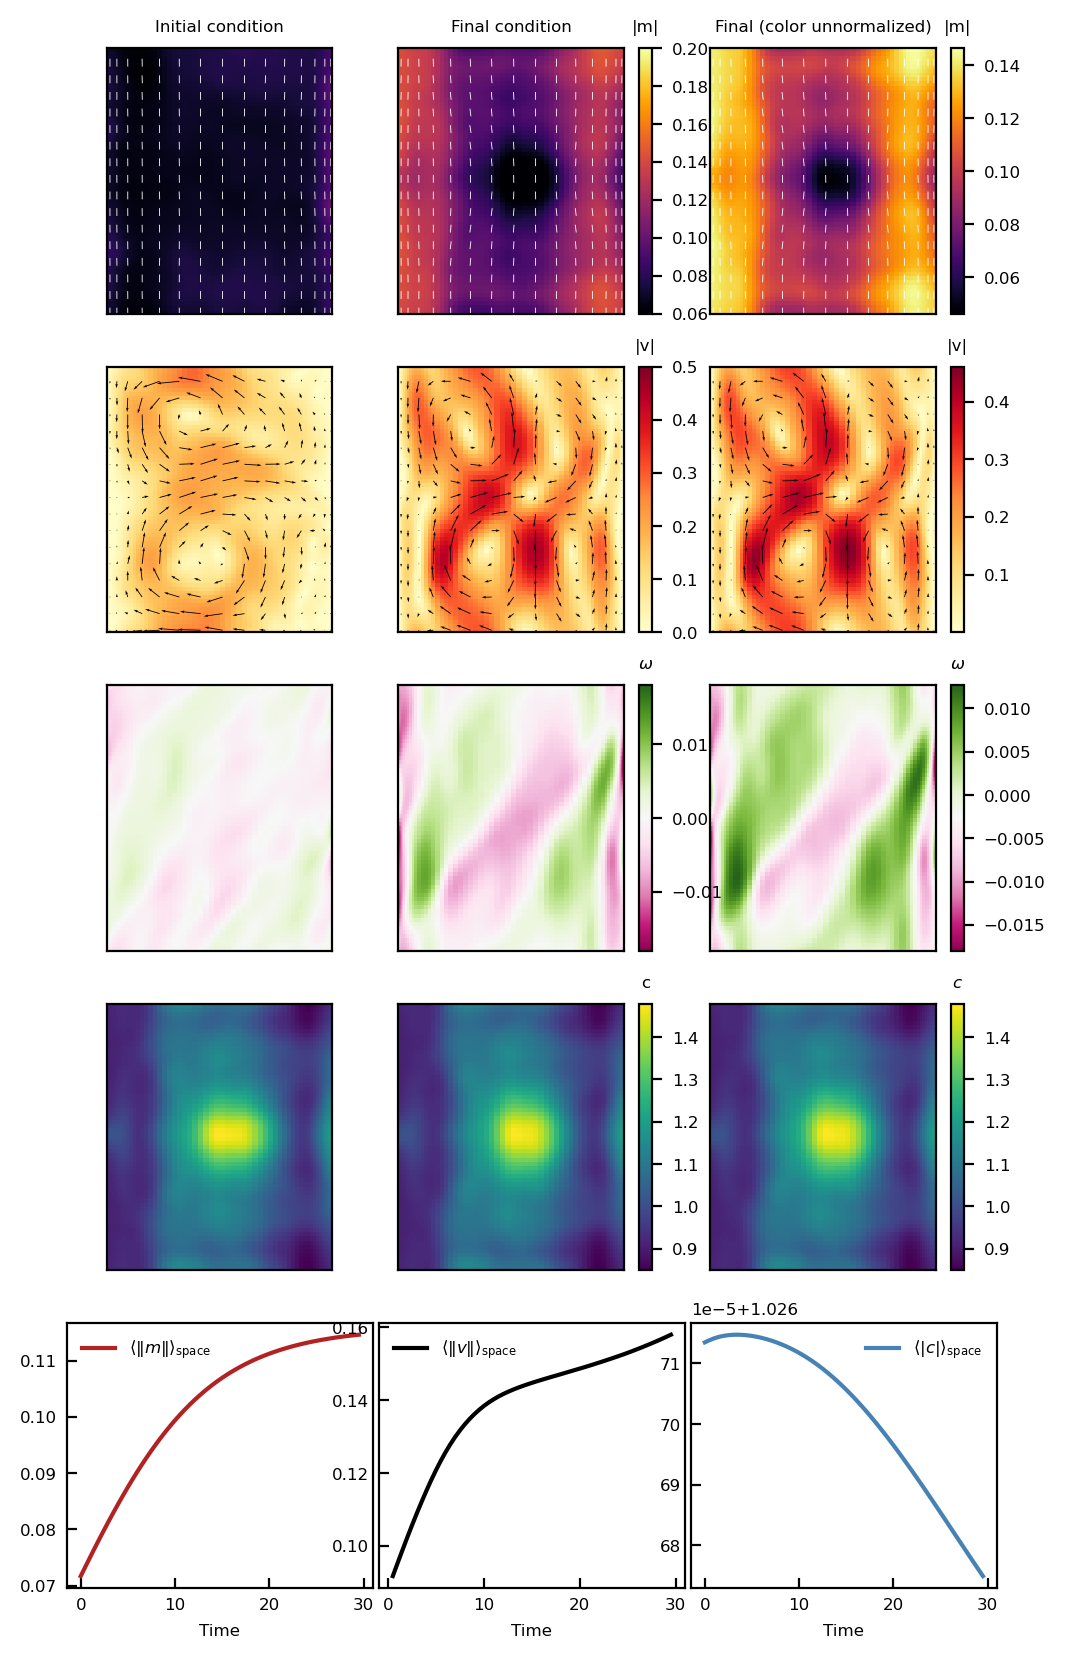

In [160]:
from scipy.interpolate import RectBivariateSpline
folder = '../for_michel/data'

tt = 0
t0 = np.load(f'{folder}/time.npy')
print(f'Initial time = {t0[tt]}')

m0 = np.load(f'{folder}/myosin.npy', mmap_mode='r')[tt]
c0 = np.load(f'{folder}/cadherin.npy', mmap_mode='r')[tt].squeeze()

params = dict(
    mu = 1., α = 3., 
    τ = 3, A = -1, C=0.5, #Base terms
    km=-0.6, kE=0.3,     #Cadherin terms
    m_ic=None, c_ic=None,
    Lx=452., Ly=533.,   #Units of microns
    Nx=64, Ny=64,
    max_time=30, timestep=0.1, save_every=5,
    m_eq='dt(m) = - (Ω @ m - m @ Ω)  - v @ grad(m) + (1 + km * c) / τ * m + A*m*trace(m) + C * (1 + kE * c) * (E @ m + m @ E)'
)
print(f'Fixed point at {-1/(params["A"]*params["τ"])}')
logging.getLogger('subsystems').setLevel('ERROR')
logger = logging.getLogger('dedalus')
logger.setLevel(logging.INFO)
data = simu(params, ics, logger)
x = np.squeeze(data["bases"][0].local_grid())
y = np.squeeze(data["bases"][1].local_grid())

kwargs = dict(vmax=.5, mmin=0.06, mmax=0.2, skip=4)
c, v, m, t = data["trajectory"]["c"], data["trajectory"]["v"], data["trajectory"]["m"], data['trajectory']['t']
plot_all(m, v, c, t, x, y, **kwargs, half=False)